### APT-36K animal class

In [1]:
DEER=1
DOG=2
CAT=3
HOURSE=4
RABBIT=5
PIG=6
CHIMPANZEE=7
MONKEY=8
ORANGUTAN=9
GORILLA=10
SPIDER_MONKEY=11
HOWLING_MONKEY=12
ZEBRA=13
ELEPHANT=14
HIPPO=15
RACCON=16
RHINO=17
GIRAFFE=18
TIGER=19
LION=20
PANDA=21
CHEETAH=22
BLACK_BEAR=23
POLAR_BEAR=24
ANTELOPE=25
FOX=26
BUFFALO=27
COW=28
WOLF=29
SHEEP=30

# Demo

모델 __init__.py 들어있는 경로로 수정 or import modules 부분 수정

In [10]:
!ls ../PCT4-classifier

configs  models  tools	utils  weights	work_dirs


In [23]:
import sys
sys.path.append('PCT')

import modules

In [3]:
from mmengine.dist import load_checkpoint

ImportError: cannot import name 'load_checkpoint' from 'mmengine.dist' (/home/sj/anaconda3/envs/torch21/lib/python3.10/site-packages/mmengine/dist/__init__.py)

In [2]:
import os
import warnings
from argparse import ArgumentParser
import copy
from collections import defaultdict

import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import mmcv
# from mmcv.runner import load_checkpoint
# from mmpose.apis import (inference_top_down_pose_model, process_mmdet_results)
from mmpose.datasets import DatasetInfo
from models import build_posenet

%matplotlib inline

# try:
from mmdet.apis import inference_detector, init_detector
has_mmdet = True

from mmdet.apis import show_result_pyplot

import torch
from mmcv.parallel import collate, scatter
from mmcv.utils.misc import deprecated_api_warning
from PIL import Image

from mmpose.datasets.pipelines import Compose, ToTensor
from mmpose.utils.hooks import OutputHook

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

ModuleNotFoundError: No module named 'mmcv.runner'

In [5]:
from mmpose.structures.bbox import bbox_xyxy2xywh, bbox_xyxy2xywh
from mmpose.evaluation.functional import oks_nms

In [25]:
class ColorStyle:
    def __init__(self, color, link_pairs, point_color):
        self.color = color
        self.link_pairs = link_pairs
        self.point_color = point_color

        for i in range(len(self.link_pairs)):
            self.link_pairs[i].append(tuple(np.array(self.color[i])/255.))

        self.ring_color = []
        for i in range(len(self.point_color)):
            self.ring_color.append(tuple(np.array(self.point_color[i])/255.))
            
            
color2 = [(240,2,127), (240,2,127), (240,2,127), 
          (169, 209, 142), (169, 209, 142),
          (0,176,240), (0,176,240), (0,176,240),
          (255,255,0), (255,255,0), (255,255,0), 
          (0,176,240), (0,176,240), (0,176,240),
          (255,255,0), (255,255,0), (255,255,0) ]

link_pairs_animal = [[0,1], [1,2], [0,2], # 얼굴 부분
                     [2,3], [3,4], # 목 & 몸통
                     [3,8], [8,9], [9,10], # 왼쪽 상체
                     [3,5], [5,6], [6,7], # 오른쪽 상체
                     [4,14], [14,15], [15,16], # 왼쪽 하체
                     [4,11], [11,12], [12,13]] # 오른쪽 하체

point_color2 = [(240,2,127),(240,2,127),(240,2,127), 
            (240,2,127), (240,2,127), 
            (255,255,0),(169, 209, 142),
            (255,255,0),(169, 209, 142),
            (255,255,0),(169, 209, 142),
            (252,176,243),(0,176,240),(252,176,243),
            (0,176,240),(252,176,243),(0,176,240),
            (255,255,0),(169, 209, 142),
            (255,255,0),(169, 209, 142),
            (255,255,0),(169, 209, 142)]

chunhua_style = ColorStyle(color2, link_pairs_animal, point_color2)

In [28]:
def init_pose_model(config, checkpoint=None, device=None):
    """Initialize a pose model from config file.

    Args:
        config (str or :obj:`mmcv.Config`): Config file path or the config
            object.
        checkpoint (str, optional): Checkpoint path. If left as None, the model
            will not load any weights.

    Returns:
        nn.Module: The constructed detector.
    """
    if isinstance(config, str):
        config = mmcv.Config.fromfile(config)
    elif not isinstance(config, mmcv.Config):
        raise TypeError('config must be a filename or Config object, '
                        f'but got {type(config)}')
    config.model.pretrained = None
    model = build_posenet(config.model)
    if checkpoint is not None:
        # load model checkpoint
        load_checkpoint(model, checkpoint, map_location='cpu')
    # save the config in the model for convenience
    model.cfg = config
    model.to(device)
    model.eval()
    return model

In [48]:
device = 'cuda:0'
bbox_thr = 0.6 # bounding box threshold
thickness = 2

In [11]:
device = 'cpu'

## build model (top-down)

1. Load Detection Model : Casacaded R-CNN

In [30]:
# detection model config & checkpoint
det_config = 'Models/DetectionModel/cascade_rcnn_x101_64x4d_fpn_coco_81class.py'
det_checkpoint = 'Models/DetectionModel/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth'
det_model = init_detector(det_config, det_checkpoint, device=device.lower())

load checkpoint from local path: Models/DetectionModel/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth


1. Load Detection Model : R-CNN (1-class version)

In [13]:
# detection model config & checkpoint
det_config = 'DetectionModel/cascade_rcnn_x101_64x4d_fpn_coco.py'
det_checkpoint = 'DetectionModel/cascade_rcnn_x101_64x4d_fpn_20e_macaque-e45e36f5_20210409.pth'
det_model = init_detector(det_config, det_checkpoint, device=device.lower())

FileNotFoundError: file "/home/sj/JeongEun/DetectionModel/cascade_rcnn_x101_64x4d_fpn_coco.py" does not exist

2. Load Pose Model: PCT

In [52]:
pose_config = 'PCT/configs/pct_base_woimgguide_classifier.py'
pose_checkpoint = 'PCT/work_dirs/pct_base_woimgguide_classifier_1/epoch_210.pth'
pose_model = init_pose_model(pose_config, pose_checkpoint, device=device.lower())

norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(16, 16)] ==> [12]
norm8_log_bylayer: [(8, 8)] ==> [6]
norm8_log_bylayer: [(8, 8)] ==> [6]
If you are training a classifier, must check that the well-trained tok

Dataset Info

In [34]:
dataset = pose_model.cfg.data['test']['type']
dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)

if dataset_info is None:
    warnings.warn(
        'Please set `dataset_info` in the config.'
        'Check https://github.com/open-mmlab/mmpose/pull/663 for details.',
        DeprecationWarning)
else:
    dataset_info = DatasetInfo(dataset_info)

print(dataset)

AnimalAP10KDataset


# functions

In [38]:
def _pipeline_gpu_speedup(pipeline, device):
    """Load images to GPU and speed up the data transforms in pipelines."""
    for t in pipeline.transforms:
        if isinstance(t, ToTensor):
            t.device = device


def _inference_single_pose_model(model, imgs_or_paths, bboxes,
                                 dataset='TopDownCocoDataset', dataset_info=None, return_heatmap=False,
                                 use_multi_frames=False, category=None):
    """Inference human bounding boxes.

    Note:
        - num_frames: F
        - num_bboxes: N
        - num_keypoints: K

    Args:
        model (nn.Module): The loaded pose model.
        imgs_or_paths (list(str) | list(np.ndarray)): Image filename(s) or
            loaded image(s)
        bboxes (list | np.ndarray): All bounding boxes (with scores),
            shaped (N, 4) or (N, 5). (left, top, width, height, [score])
            where N is number of bounding boxes.
        dataset (str): Dataset name. Deprecated.
        dataset_info (DatasetInfo): A class containing all dataset info.
        return_heatmap (bool): Flag to return heatmap, default: False
        use_multi_frames (bool): Flag to use multi frames for inference

    Returns:
        ndarray[NxKx3]: Predicted pose x, y, score.
        heatmap[N, K, H, W]: Model output heatmap.
    """ 

    cfg = model.cfg
    device = next(model.parameters()).device
    if device.type == 'cpu':
        device = -1

    if use_multi_frames:
        assert 'frame_weight_test' in cfg.data.test.data_cfg
        # use multi frames for inference
        # the number of input frames must equal to frame weight in the config
        assert len(imgs_or_paths) == len(
            cfg.data.test.data_cfg.frame_weight_test)

    # build the data pipeline
    _test_pipeline = copy.deepcopy(cfg.test_pipeline)

    has_bbox_xywh2cs = False
    for transform in _test_pipeline:
        if transform['type'] == 'TopDownGetBboxCenterScale':
            has_bbox_xywh2cs = True
            break
    if not has_bbox_xywh2cs:
        _test_pipeline.insert(
            0, dict(type='TopDownGetBboxCenterScale', padding=1.25))
    test_pipeline = Compose(_test_pipeline)
    _pipeline_gpu_speedup(test_pipeline, next(model.parameters()).device)

    assert len(bboxes[0]) in [4, 5]

    assert dataset_info is not None, "dataset_info must not be None"
    dataset_name = dataset_info.dataset_name
    flip_pairs = dataset_info.flip_pairs


    batch_data = []
    for bbox in bboxes:
        # prepare data
        data = {
            'bbox':
            bbox,
            'bbox_score':
            bbox[4] if len(bbox) == 5 else 1,
            'bbox_id':
            0,  # need to be assigned if batch_size > 1
            'dataset':
            dataset_name,
            'joints_3d':
            np.zeros((cfg.data_cfg.num_joints, 3), dtype=np.float32),
            'joints_3d_visible':
            np.zeros((cfg.data_cfg.num_joints, 3), dtype=np.float32),
            'rotation':
            0,
            'ann_info': {
                'image_size': np.array(cfg.data_cfg['image_size']),
                'num_joints': cfg.data_cfg['num_joints'],
                'flip_pairs': flip_pairs
            },
            # add annotation category (name from config file)
            'category':category
        }


        if use_multi_frames:
            # weight for different frames in multi-frame inference setting
            data['frame_weight'] = cfg.data.test.data_cfg.frame_weight_test
            if isinstance(imgs_or_paths[0], np.ndarray):
                data['img'] = imgs_or_paths
            else:
                data['image_file'] = imgs_or_paths
        else:
            if isinstance(imgs_or_paths, np.ndarray):
                data['img'] = imgs_or_paths
            else:
                data['image_file'] = imgs_or_paths


        data = test_pipeline(data)
        batch_data.append(data)
    

    batch_data = collate(batch_data, samples_per_gpu=len(batch_data))
    batch_data = scatter(batch_data, [device])[0]

    # forward the model
    with torch.no_grad():
        result = model(
            img=batch_data['img'],
            img_metas=batch_data['img_metas'],
            return_loss=False,
            return_heatmap=return_heatmap)

    return result['preds'], result['output_heatmap']


# @deprecated_api_warning(name_dict=dict(img_or_path='imgs_or_paths'))
def inference_top_down_pose_model(model, imgs_or_paths, person_results=None, bbox_thr=None, format='xywh',
                                  dataset='TopDownCocoDataset', dataset_info=None, return_heatmap=False, 
                                  outputs=None, category=None):
    
    # decide whether to use multi frames for inference
    if isinstance(imgs_or_paths, (list, tuple)):
        use_multi_frames = True
    else:
        assert isinstance(imgs_or_paths, (str, np.ndarray))
        use_multi_frames = False
    # get dataset info
    if (dataset_info is None and hasattr(model, 'cfg')
            and 'dataset_info' in model.cfg):
        dataset_info = DatasetInfo(model.cfg.dataset_info)
    if dataset_info is None:
        warnings.warn(
            'dataset is deprecated.'
            'Please set `dataset_info` in the config.'
            'Check https://github.com/open-mmlab/mmpose/pull/663'
            ' for details.', DeprecationWarning)

    # only two kinds of bbox format is supported.
    assert format in ['xyxy', 'xywh']

    pose_results = []
    returned_outputs = []

    if person_results is None:
        # create dummy person results
        sample = imgs_or_paths[0] if use_multi_frames else imgs_or_paths
        if isinstance(sample, str):
            width, height = Image.open(sample).size
        else:
            height, width = sample.shape[:2]
        person_results = [{'bbox': np.array([0, 0, width, height])}]

    if len(person_results) == 0:
        return pose_results, returned_outputs

    # Change for-loop preprocess each bbox to preprocess all bboxes at once.
    bboxes = np.array([box['bbox'] for box in person_results])

    # Select bboxes by score threshold
    if bbox_thr is not None:
        assert bboxes.shape[1] == 5
        valid_idx = np.where(bboxes[:, 4] > bbox_thr)[0]
        bboxes = bboxes[valid_idx]
        person_results = [person_results[i] for i in valid_idx]

    if format == 'xyxy':
        bboxes_xyxy = bboxes
        bboxes_xywh = bbox_xyxy2xywh(bboxes)
    else:
        # format is already 'xywh'
        bboxes_xywh = bboxes
        bboxes_xyxy = bbox_xywh2xyxy(bboxes)

    # if bbox_thr remove all bounding box
    if len(bboxes_xywh) == 0:
        return [], []

    with OutputHook(model, outputs=outputs, as_tensor=False) as h:
        # poses is results['pred'] # N x 17x 3
        poses, heatmap = _inference_single_pose_model(
            # 여기에 카테고리가 들어가야 하지 않나 ...
            model,
            imgs_or_paths,
            bboxes_xywh,
            dataset=dataset,
            dataset_info=dataset_info,
            return_heatmap=return_heatmap,
            use_multi_frames=use_multi_frames,
            category=category)

        if return_heatmap:
            h.layer_outputs['heatmap'] = heatmap

        returned_outputs.append(h.layer_outputs)

    assert len(poses) == len(person_results), print(
        len(poses), len(person_results), len(bboxes_xyxy))
    for pose, person_result, bbox_xyxy in zip(poses, person_results,
                                              bboxes_xyxy):
        pose_result = person_result.copy()
        pose_result['keypoints'] = pose
        pose_result['bbox'] = bbox_xyxy
        pose_results.append(pose_result)

    return pose_results, returned_outputs

In [37]:
def my_process_mmdet_results(mmdet_results, cat_id):
    if isinstance(mmdet_results, tuple):
        det_results = mmdet_results[0]
    else:
        det_results = mmdet_results

    bboxes = []
    for cls in cat_id:
        for re in det_results[cls - 1]:
            bboxes.append(re)

    person_results = []
    for bbox in bboxes:
        person = {}
        person['bbox'] = bbox
        person_results.append(person)

    return person_results

def map_joint_dict(joints):
    joints_dict = {}
    for i in range(joints.shape[0]):
        x = int(joints[i][0])
        y = int(joints[i][1])
        id = i
        joints_dict[id] = (x, y) 
        
    return joints_dict

def vis_pose_result(image_name, pose_results, thickness):
    
    data_numpy = cv2.imread(image_name, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

    h = data_numpy.shape[0]
    w = data_numpy.shape[1]
        
    # Plot

    fig = plt.figure(figsize=(w/100, h/100), dpi=80)
    ax = plt.subplot(1,1,1)
    bk = plt.imshow(data_numpy[:,:,::-1])
    bk.set_zorder(-1)
    
    for i, dt in enumerate(pose_results[:]):
        dt_joints = np.array(dt['keypoints']).reshape(17,-1)
        joints_dict = map_joint_dict(dt_joints) # 각 키포인트의 좌표
        
        # stick 
        for k, link_pair in enumerate(chunhua_style.link_pairs):
            if k in range(11,16):
                lw = thickness
            else:
                lw = thickness * 2

            line = mlines.Line2D(
                    np.array([joints_dict[link_pair[0]][0],
                                joints_dict[link_pair[1]][0]]),
                    np.array([joints_dict[link_pair[0]][1],
                                joints_dict[link_pair[1]][1]]),
                    ls='-', lw=lw, alpha=1, color=link_pair[2],)

            line.set_zorder(0)
            ax.add_line(line)

        # black ring
        for k in range(dt_joints.shape[0]):
            if k in range(5):
                radius = thickness
            else:
                radius = thickness * 2

            circle = mpatches.Circle(tuple(dt_joints[k,:2]), 
                                        radius=radius, 
                                        ec='black', 
                                        fc=chunhua_style.ring_color[k], 
                                        alpha=1, 
                                        linewidth=1)
            circle.set_zorder(1)
            ax.add_patch(circle)
        
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.axis('off')
    plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)        
    plt.margins(0,0)
    plt.show()
    plt.close()


# Inference

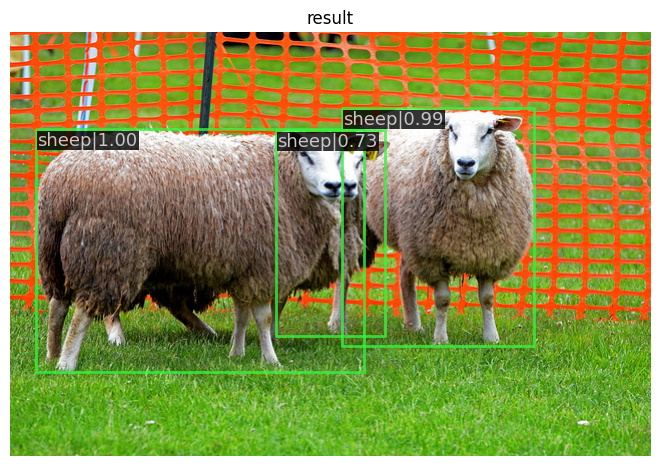

In [53]:
img_root = 'examples/coco_train2017'
file = '000000000772.jpg'

image_name = os.path.join(img_root, file)
mmdet_results = inference_detector(det_model, image_name)
# person_results = process_mmdet_results(mmdet_results, det_cat_id)

non_empty_indices = [i for i, arr in enumerate(mmdet_results) if len(arr) > 0]
# print(non_empty_indices)

show_result_pyplot(det_model, image_name, mmdet_results)

In [26]:
non_empty_indices

[16, 18, 19]

In [40]:
def inference(img, det_cat_id, category):
    
    image_name = os.path.join(img_root, img)
    image_name

    mmdet_results = inference_detector(det_model, image_name)
    person_results = my_process_mmdet_results(mmdet_results, det_cat_id)

    pose_results, returned_outputs = inference_top_down_pose_model(
        pose_model,
        image_name,
        person_results,
        bbox_thr=bbox_thr,
        format='xyxy',
        dataset=dataset,
        dataset_info=dataset_info,
        return_heatmap=False,
        outputs=None,
        category=category)
    
    vis_pose_result(image_name, pose_results, thickness=2)



In [44]:
!ls examples/coco_train2017

000000000034.jpg  000000000575.jpg  000000000996.jpg  000000001667.jpg
000000000081.jpg  000000000623.jpg  000000001589.jpg  000000001668.jpg
000000000428.jpg  000000000772.jpg  000000001622.jpg
000000000474.jpg  000000000797.jpg  000000001626.jpg


In [64]:
!ls 'examples/APT-36K'

cat1.jpg  deer1.jpg	 elephant2.jpg	PANDA1.jpg  sheep1.jpg
cat2.jpg  deer2.jpg	 example1.jpg	PANDA2.jpg  sheep2.jpg
cat3.jpg  deer3.jpg	 example2.jpg	PANDA3.jpg  sheep3.jpg
cat4.jpg  elephant1.jpg  lion1.jpg	PANDA4.jpg


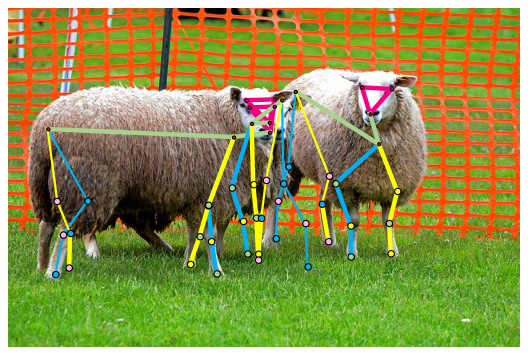

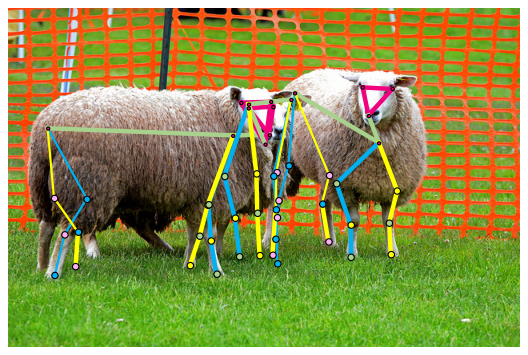

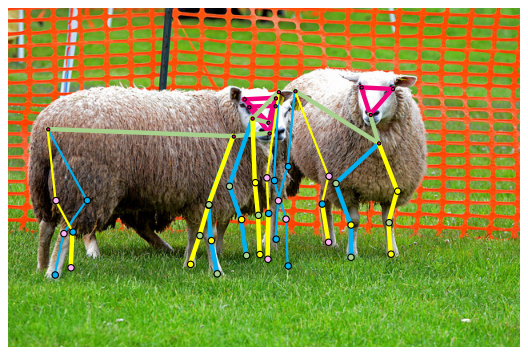

In [54]:
img_root = 'examples/coco_train2017'
file = '000000000772.jpg'
image_name = os.path.join(img_root, file)
detected_cls = [17, 19, 20]
inference(file, detected_cls, DOG)
inference(file, detected_cls, ELEPHANT)
inference(file, detected_cls, SHEEP)